# 2D SSN Model

In this notebook:
- training script for SSN model
- implementation of vmap

Information on training vmap:
- https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html
- https://jax.readthedocs.io/en/latest/notebooks/Neural_Network_and_Data_Loading.html

Information on colour plot:
https://www.statology.org/matplotlib-scatterplot-color-by-value/

Imports

In [4]:
import matplotlib.pyplot as plt
import time, os, json
import pandas as pd
from scipy import stats 
from tqdm import tqdm
import seaborn as sns
import jax
from jax import random
from jax.config import config 
import jax.numpy as np
from jax import vmap
import pdb
import optax
import time
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader


#config.update('jax_debug_nans', True)
from SSN_classes_jax import SSN2DTopoV1_AMPAGABA_ONOFF
from util import GaborFilter, BW_Grating, find_A, create_gabor_filters, create_gratings

## GENERATE DATA

In [9]:
#Gabor parameters 
sigma_g= 0.5
k = np.pi/(6*sigma_g)

#Parameters shared with stimuli
general_pars = dict(k=k , edge_deg=3.2,  degree_per_pixel=0.05)
#Stimuli parameters
stimuli_pars = dict(outer_radius=3, inner_radius=2.5, grating_contrast=0.8)
stimuli_pars.update(general_pars)

#SPECIFY JITTER AND SNR
jitter_val = 5
snr = 1

In [139]:
#Create gratings at given or ientation and list of labels
data = create_gratings(ref_ori=55, number=250, offset= 5, jitter_val=jitter_val, snr = snr, **stimuli_pars)
train, test = train_test_split(data, test_size = 0.2)
len(train), len(test)

#batch params 
batch_size= 20
train_dataloader =DataLoader(train, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test, batch_size=len(test), shuffle=False)
number_batches= int(len(train) / batch_size)
number_batches

10

# MODEL TRAINING

1. Define parameters

In [140]:
#Network parameters
class ssn_pars():
    n = 2
    k = 0.04
    tauE = 30 # in ms
    tauI = 10 # in ms
    psi = 0.774
    tau_s = np.array([5, 7, 100]) #in ms, AMPA, GABA, NMDA current decay time constants
    

#Grid parameters
class grid_pars():
    gridsize_Nx = 9 # grid-points across each edge # gives rise to dx = 0.8 mm
    gridsize_deg = 2 * 1.6 # edge length in degrees
    magnif_factor = 2  # mm/deg
    hyper_col = 0.8 # mm   
    sigma_RF = 0.4 # deg (visual angle)

# Caleb's params for the full (with local) model:
Js0 = [1.82650658, 0.68194475, 2.06815311, 0.5106321]
gE, gI = 0.57328625, 0.26144141

sigEE, sigIE = 0.2, 0.40
sigEI, sigII = .09, .09
conn_pars = dict(
    PERIODIC = False,
    p_local = [.4, 0.7], # [p_local_EE, p_local_IE],
    sigma_oris = 1000) # sigma_oris


make_J2x2 = lambda Jee, Jei, Jie, Jii: np.array([[Jee, -Jei], [Jie,  -Jii]]) * np.pi * ssn_pars.psi
J_2x2 = make_J2x2(*Js0)
s_2x2 = np.array([[sigEE, sigEI],[sigIE, sigII]])

#Positive reparameterization
signs=np.array([[1, -1], [1, -1]])
logJ_2x2 =np.log(J_2x2*signs)
logs_2x2 = np.log(s_2x2)


#Sigmoid parameters
N_neurons = 25
key = random.PRNGKey(5)
w_sig = random.normal(key, shape = (N_neurons,)) / np.sqrt(N_neurons)
b_sig = 0.0


#Optimization pars
opt_pars = dict(logJ_2x2 = logJ_2x2, logs_2x2 = logs_2x2, w_sig = w_sig, b_sig=b_sig)


#Parameters exclusive to Gabor filters
filter_pars = dict(sigma_g = sigma_g, conv_factor = grid_pars.magnif_factor)
filter_pars.update(general_pars) 

#Convergence parameters
conv_pars=dict(dt = 1, xtol = 1e-5, Tmax = 200, verbose=False, silent=True)

3. TRAINING!

# Vmap implementation

In [152]:
def sigmoid(x):
    return 1/(1+np.exp(x))

def binary_loss(n, x):
    return - (n*np.log(x) + (1-n)*np.log(1-x))

def model(opt_pars, ssn_pars, grid_pars, conn_pars, train_data, filter_pars,  conv_pars):
    
    signs=np.array([[1, -1], [1, -1]])
    
    J_2x2 =np.exp(opt_pars['logJ_2x2'])*signs
    s_2x2 = np.exp(opt_pars['logs_2x2'])
    
    #Initialise network
    ssn=SSN2DTopoV1_AMPAGABA_ONOFF(ssn_pars=ssn_pars, grid_pars=grid_pars, conn_pars=conn_pars, filter_pars=filter_pars, J_2x2=J_2x2, s_2x2=s_2x2)

    #Apply Gabor filters to stimuli
    output_ref=np.matmul(ssn.gabor_filters, train_data['ref'])*ssn.A
    output_target=np.matmul(ssn.gabor_filters, train_data['target'])*ssn.A

    #Rectify output
    SSN_input_ref=np.maximum(0, output_ref)
    SSN_input_target=np.maximum(0, output_target)

    #Input to SSN
    r_init = np.zeros(SSN_input_ref.shape[0])

    fp_ref, _ = ssn.fixed_point_r(SSN_input_ref, r_init=r_init, **conv_pars)
    x_ref = ssn.apply_bounding_box(fp_ref, size=3.2)

    fp_target, _ = ssn.fixed_point_r(SSN_input_target, r_init=r_init, **conv_pars)
    x_target = ssn.apply_bounding_box(fp_target, size=3.2)

    #Apply sigmoid function - combine ref and target
    x = sigmoid( np.dot(opt_pars['w_sig'], (x_ref.ravel() - x_target.ravel())) + opt_pars['b_sig'])

    #Calculate binary cross entropy loss
    loss=binary_loss(train_data['label'], x)
   
    return loss


def loss(opt_pars, ssn_pars, grid_pars, conn_pars, train_data, filter_pars,  conv_pars):
    '''
    Calculate parallelized loss for batch of data through vmap.
    Output:
        mean loss of all the input images
    '''
    
    vmap_model = vmap(model, in_axes = ({'b_sig': None, 'logJ_2x2': None, 'logs_2x2': None, 'w_sig': None}, None, None, {'PERIODIC': None, 'p_local': [None, None], 'sigma_oris': None},  {'ref':0, 'target':0, 'label':0}, {'conv_factor': None, 'degree_per_pixel': None, 'edge_deg': None, 'k': None, 'sigma_g': None}, {'Tmax': None, 'dt': None, 'silent': None, 'verbose': None, 'xtol': None}) )                   
    loss = np.sum(vmap_model(opt_pars, ssn_pars, grid_pars, conn_pars, train_data, filter_pars,  conv_pars))

    return loss


def train_SSN_vmap(opt_pars, ssn_pars, grid_pars, conn_pars, train_dataloader, test_dataloader, filter_pars, conv_pars, batches, epochs=1, eta=10e-4):
    
    #Initialize loss
    val_loss_per_epoch = []
    training_losses=[]
    accuracies=[]
    
    #Initialise optimizer
    optimizer = optax.adam(eta)
    opt_state = optimizer.init(opt_pars)
    
    #Define test data - no need to iterate
    test_iterator = iter(test_dataloader)
    test_data = next(test_iterator)
    test_data['ref'] = test_data['ref'].numpy()
    test_data['target'] = test_data['target'].numpy()
    test_data['label'] = test_data['label'].numpy()
    
    val_loss, accuracy, _= vmap_eval(opt_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars)

    print('Before training  -- loss: {}, accuracy: {} '.format(val_loss, accuracy))
    val_loss_per_epoch.append(val_loss)
    accuracies.append(accuracy)

    
    for epoch in range(epochs):
        start_time = time.time()
        train_iterator = iter(train_dataloader)
        epoch_loss = 0 
           
        #Iterate through data in batches
        for batch in range(batches): 

            #load next batch of data and convert
            train_data = next(train_iterator)
            #convert tensors to numpy
            train_data['ref'] = train_data['ref'].numpy()
            train_data['target'] = train_data['target'].numpy()
            train_data['label'] = train_data['label'].numpy()
            
            #Compute loss and gradient
            batch_loss, grad =jax.value_and_grad(loss)(opt_pars, ssn_pars, grid_pars, conn_pars, train_data, filter_pars,  conv_pars)
            
            #Apply SGD through Adam optimizer per batch
            updates, opt_state = optimizer.update(grad, opt_state)
            opt_pars = optax.apply_updates(opt_pars, updates)
            epoch_loss+=batch_loss
        
        epoch_time = time.time() - start_time
        
        
        #Evaluate model at the end of each epoch
        val_loss, accuracy, _= vmap_eval(opt_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars)
        print('Training loss: {} ¦ Validation -- loss: {}, accuracy: {} at epoch {}, (time {})'.format(epoch_loss, val_loss, accuracy, epoch+1, epoch_time))
        val_loss_per_epoch.append(val_loss)
        training_losses.append(epoch_loss)
        accuracies.append(accuracy)
    
    #reparametize parameters
    signs=np.array([[1, -1], [1, -1]])    
    opt_pars['logJ_2x2'] = np.exp(opt_pars['logJ_2x2'])*signs
    opt_pars['logs_2x2'] = np.exp(opt_pars['logs_2x2'])
    
    return opt_pars, val_loss_per_epoch, accuracies


def eval_model(opt_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars):
    signs=np.array([[1, -1], [1, -1]])
    
    J_2x2 =np.exp(opt_pars['logJ_2x2'])*signs
    s_2x2 = np.exp(opt_pars['logs_2x2'])
    
    #Initialise network
    ssn=SSN2DTopoV1_AMPAGABA_ONOFF(ssn_pars=ssn_pars, grid_pars=grid_pars, conn_pars=conn_pars, filter_pars=filter_pars, J_2x2=J_2x2, s_2x2=s_2x2)

    #Apply Gabor filters to stimuli
    output_ref=np.matmul(ssn.gabor_filters, test_data['ref'])*ssn.A
    output_target=np.matmul(ssn.gabor_filters, test_data['target'])*ssn.A

    #Rectify output
    SSN_input_ref=np.maximum(0, output_ref)
    SSN_input_target=np.maximum(0, output_target)

    #Input to SSN
    r_init = np.zeros(SSN_input_ref.shape[0])

    fp_ref, _ = ssn.fixed_point_r(SSN_input_ref, r_init=r_init, **conv_pars)
    x_ref = ssn.apply_bounding_box(fp_ref, size=3.2)

    fp_target, _ = ssn.fixed_point_r(SSN_input_target, r_init=r_init, **conv_pars)
    x_target = ssn.apply_bounding_box(fp_target, size=3.2)
    
    dot= np.dot(opt_pars['w_sig'], (x_ref.ravel() - x_target.ravel()))

    #Apply sigmoid function - combine ref and target
    x = sigmoid( np.dot(opt_pars['w_sig'], (x_ref.ravel() - x_target.ravel())) + opt_pars['b_sig'])
    
    #compare prediction to label
    pred_label = np.round(x)

    #Calculate binary cross entropy loss
    loss=binary_loss(test_data['label'], x)
    
    return loss, pred_label, x

def vmap_eval(opt_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars):
    
    eval_vmap = vmap(eval_model, in_axes = ({'b_sig': None, 'logJ_2x2': None, 'logs_2x2': None, 'w_sig': None}, None, None, {'PERIODIC': None, 'p_local': [None, None], 'sigma_oris': None},  {'ref':0, 'target':0, 'label':0}, {'conv_factor': None, 'degree_per_pixel': None, 'edge_deg': None, 'k': None, 'sigma_g': None}, {'Tmax': None, 'dt': None, 'silent': None, 'verbose': None, 'xtol': None}) )
    losses, pred_labels, dots = eval_vmap(opt_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars)
    
    accuracy = np.sum(test_data['label'] == pred_labels)/len(test_data['label']) 
    
    vmap_loss= np.mean(losses)
    
    return vmap_loss, accuracy, dots

In [142]:
#OFFSET - 5, eta = 10e-4
vmap_pars, vmap_val_loss, acc = train_SSN_vmap(opt_pars, ssn_pars, grid_pars, conn_pars, train_dataloader, test_dataloader, filter_pars,  conv_pars, batches = number_batches, epochs = 20)

Before training  -- loss: 1.1997320652008057, accuracy: 0.30000001192092896 
Training loss: 220.72244262695312 ¦ Validation -- loss: 1.0649776458740234, accuracy: 0.30000001192092896 at epoch 1, (time 58.18189191818237)
Training loss: 199.41714477539062 ¦ Validation -- loss: 0.9724718332290649, accuracy: 0.2800000011920929 at epoch 2, (time 53.276920795440674)
Training loss: 184.70814514160156 ¦ Validation -- loss: 0.9053971767425537, accuracy: 0.30000001192092896 at epoch 3, (time 55.450644731521606)
Training loss: 173.71746826171875 ¦ Validation -- loss: 0.8516440987586975, accuracy: 0.3199999928474426 at epoch 4, (time 54.808478593826294)
Training loss: 164.56625366210938 ¦ Validation -- loss: 0.8031469583511353, accuracy: 0.3400000035762787 at epoch 5, (time 54.14954161643982)
Training loss: 155.97740173339844 ¦ Validation -- loss: 0.7539035081863403, accuracy: 0.36000001430511475 at epoch 6, (time 53.964396953582764)
Training loss: 146.9121856689453 ¦ Validation -- loss: 0.6983065

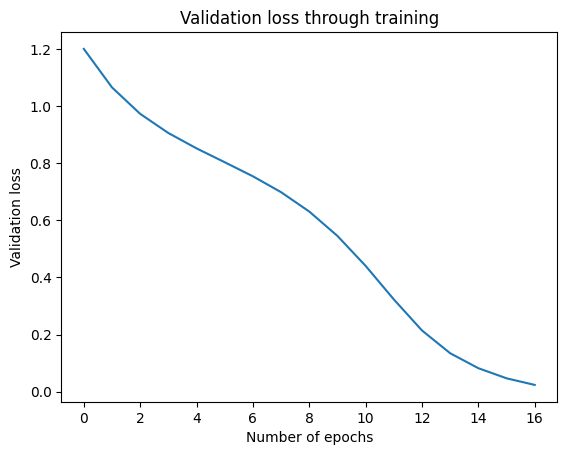

In [150]:
plt.plot(vmap_val_loss)
plt.xlabel('Number of epochs')
plt.ylabel('Validation loss')
plt.title('Validation loss through training')
plt.savefig('val_loss.png')
plt.show()


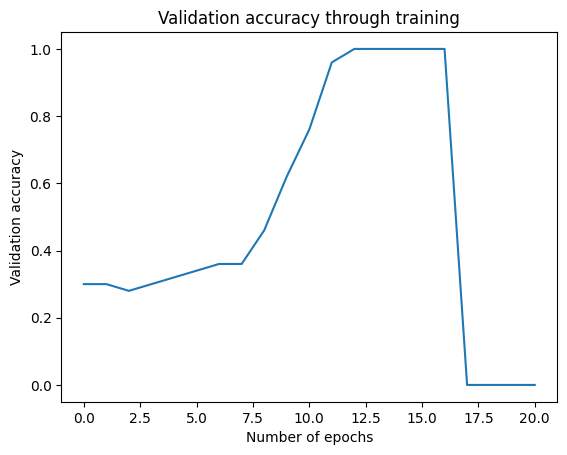

In [151]:
plt.plot(acc)
plt.xlabel('Number of epochs')
plt.ylabel('Validation accuracy')
plt.title('Validation accuracy through training')
plt.savefig('val_accuracy.png')
plt.show()

In [ ]:
#OFFSET - 05, eta = 10e-4
vmap_pars_05, vmap_val_loss_05, acc_05 = train_SSN_vmap(opt_pars, ssn_pars, grid_pars, conn_pars, train_dataloader, test_dataloader, filter_pars,  conv_pars, batches = number_batches, epochs = 20)

## TESTS

In [12]:
def create_testing_data(stimuli_pars, jitter_val, snr, number=100, offset = 5, ref_ori=55):
    
    '''
    Create data for given jitter and snr value for testing (not dataloader)
    '''
    data = create_gratings(ref_ori=ref_ori, number=number, offset=offset, jitter_val=jitter_val, snr=snr, **stimuli_pars)
    train_data = next(iter(DataLoader(data, batch_size=len(data), shuffle=False)))
    train_data['ref'] = train_data['ref'].numpy()
    train_data['target'] = train_data['target'].numpy()
    train_data['label'] = train_data['label'].numpy()
    
    return train_data

### 1. Testing accuracies of different initializations

In [120]:
def vmap_eval2(opt_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars):
    
    eval_vmap = vmap(eval_model, in_axes = ({'b_sig': None, 'logJ_2x2': None, 'logs_2x2': None, 'w_sig': None}, None, None, {'PERIODIC': None, 'p_local': [None, None], 'sigma_oris': None},  {'ref':0, 'target':0, 'label':0}, {'conv_factor': None, 'degree_per_pixel': None, 'edge_deg': None, 'k': None, 'sigma_g': None}, {'Tmax': None, 'dt': None, 'silent': None, 'verbose': None, 'xtol': None}) )
    losses, pred_labels, dots = eval_vmap(opt_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars)
        
    accuracy = np.sum(test_data['label'] == pred_labels)/len(test_data['label']) 
    
    return losses, accuracy, dots

def vmap_eval3(opt_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars):

    eval_vmap = vmap(vmap_eval2, in_axes = ({'b_sig': None, 'logJ_2x2': None, 'logs_2x2': None, 'w_sig': 0}, None, None, {'PERIODIC': None, 'p_local': [None, None], 'sigma_oris': None},  {'ref':None, 'target':None, 'label':None}, {'conv_factor': None, 'degree_per_pixel': None, 'edge_deg': None, 'k': None, 'sigma_g': None}, {'Tmax': None, 'dt': None, 'silent': None, 'verbose': None, 'xtol': None}) )
    losses, accuracies, dots = eval_vmap(opt_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars)
    
    return losses, accuracies
    
    
def test_accuracies(opt_pars, ssn_pars, grid_pars, conn_pars, filter_pars,  conv_pars, stimuli_pars, jitter_val, snr, trials = 5, p = 0.9):
    
    key = random.PRNGKey(7)
    N_neurons = 25
    accuracies = []
    key, _ = random.split(key)
    opt_pars['w_sig'] = random.normal(key, shape = (trials, N_neurons)) / np.sqrt(N_neurons)
    
    train_data = create_testing_data(stimuli_pars, jitter_val, snr)
    
    
    val_loss, accuracies = vmap_eval3(opt_pars, ssn_pars, grid_pars, conn_pars, train_data, filter_pars,  conv_pars)
    
    #calcualate how many accuracies are above 90
    higher_90 = np.sum(accuracies[accuracies>p]) / len(accuracies)

    
    print('grating contrast = {}, snr = {}, jitter = {}, acc (% >90 ) = {}'.format(stimuli_pars['grating_contrast'], snr, jitter_val, higher_90))
    return higher_90

In [121]:
#GRATING CONTRAST - 0.8
stimuli_pars['grating_contrast'] = 0.8
acc_j0_snr_0_c_08= test_accuracies(opt_pars, ssn_pars, grid_pars, conn_pars, filter_pars,  conv_pars, stimuli_pars, jitter_val=0, snr=0, trials=100)

grating contrast = 0.8, snr = 0, jitter = 0, acc (% >90 ) = 0.0


In [84]:
#GRATING CONTRAST - 0.5
stimuli_pars['grating_contrast'] = 0.2
acc_j0_snr_0_c_02= test_accuracies(opt_pars, ssn_pars, grid_pars, conn_pars, filter_pars,  conv_pars, stimuli_pars, jitter_val=0, snr=0, trials=100)
acc_j0_snr_025_c_02= test_accuracies(opt_pars, ssn_pars, grid_pars, conn_pars, filter_pars,  conv_pars, stimuli_pars, jitter_val=0, snr=0.25, trials=100)
acc_j0_snr_05_c_02= test_accuracies(opt_pars, ssn_pars, grid_pars, conn_pars, filter_pars,  conv_pars, stimuli_pars, jitter_val=0, snr=0.5, trials=100)
acc_j0_snr_1_c_02= test_accuracies(opt_pars, ssn_pars, grid_pars, conn_pars, filter_pars,  conv_pars, stimuli_pars, jitter_val=0, snr=1, trials=100)

acc_j5_snr_0_c_02= test_accuracies(opt_pars, ssn_pars, grid_pars, conn_pars, filter_pars,  conv_pars, stimuli_pars, jitter_val=5, snr=0, trials=100)
acc_j5_snr_025_c_02= test_accuracies(opt_pars, ssn_pars, grid_pars, conn_pars, filter_pars,  conv_pars, stimuli_pars, jitter_val=5, snr=0.25, trials=100)
acc_j5_snr_05_c_02= test_accuracies(opt_pars, ssn_pars, grid_pars, conn_pars, filter_pars,  conv_pars, stimuli_pars, jitter_val=5, snr=0.5, trials=100)
acc_j5_snr_1_c_02= test_accuracies(opt_pars, ssn_pars, grid_pars, conn_pars, filter_pars,  conv_pars, stimuli_pars, jitter_val=5, snr=1, trials=100)

grating contrast = 0.2, snr = 0, jitter = 0, acc (90% percentile) = 0.5709999799728394
grating contrast = 0.2, snr = 0.25, jitter = 0, acc (90% percentile) = 0.640999972820282
grating contrast = 0.2, snr = 0.5, jitter = 0, acc (90% percentile) = 0.8309999704360962
grating contrast = 0.2, snr = 1, jitter = 0, acc (90% percentile) = 1.0


KeyboardInterrupt: 

In [129]:
import numpy
list_snrs = np.linspace(0,1,11)
list_jitters = np.linspace(0, 5, 11)
grid_matrix = numpy.zeros((121,3))
count = 0

for snr in list_snrs:
    for jitter in list_jitters:
        acc = test_accuracies(opt_pars, ssn_pars, grid_pars, conn_pars, filter_pars,  conv_pars, stimuli_pars, jitter_val=jitter, snr=snr, trials=100)
        grid_matrix[count, 0] = jitter
        grid_matrix[count, 1] = snr
        grid_matrix[count,2 ] = acc
        count=count+1
        
grid_matrix        

grating contrast = 0.8, snr = 0.0, jitter = 0.0, acc (% >90 ) = 0.0
grating contrast = 0.8, snr = 0.0, jitter = 0.5, acc (% >90 ) = 0.0
grating contrast = 0.8, snr = 0.0, jitter = 1.0, acc (% >90 ) = 0.0
grating contrast = 0.8, snr = 0.0, jitter = 1.5, acc (% >90 ) = 0.0
grating contrast = 0.8, snr = 0.0, jitter = 2.0, acc (% >90 ) = 0.0
grating contrast = 0.8, snr = 0.0, jitter = 2.5, acc (% >90 ) = 0.0
grating contrast = 0.8, snr = 0.0, jitter = 3.0, acc (% >90 ) = 0.0
grating contrast = 0.8, snr = 0.0, jitter = 3.5, acc (% >90 ) = 0.0
grating contrast = 0.8, snr = 0.0, jitter = 4.0, acc (% >90 ) = 0.0
grating contrast = 0.8, snr = 0.0, jitter = 4.5, acc (% >90 ) = 0.0
grating contrast = 0.8, snr = 0.0, jitter = 5.0, acc (% >90 ) = 0.0
grating contrast = 0.8, snr = 0.10000000149011612, jitter = 0.0, acc (% >90 ) = 0.0
grating contrast = 0.8, snr = 0.10000000149011612, jitter = 0.5, acc (% >90 ) = 0.0
grating contrast = 0.8, snr = 0.10000000149011612, jitter = 1.0, acc (% >90 ) = 0.0


grating contrast = 0.8, snr = 0.800000011920929, jitter = 1.0, acc (% >90 ) = 0.20679998397827148
grating contrast = 0.8, snr = 0.800000011920929, jitter = 1.5, acc (% >90 ) = 0.19580000638961792
grating contrast = 0.8, snr = 0.800000011920929, jitter = 2.0, acc (% >90 ) = 0.18440000712871552
grating contrast = 0.8, snr = 0.800000011920929, jitter = 2.5, acc (% >90 ) = 0.1451999992132187
grating contrast = 0.8, snr = 0.800000011920929, jitter = 3.0, acc (% >90 ) = 0.13490000367164612
grating contrast = 0.8, snr = 0.800000011920929, jitter = 3.5, acc (% >90 ) = 0.11569999903440475
grating contrast = 0.8, snr = 0.800000011920929, jitter = 4.0, acc (% >90 ) = 0.12459999322891235
grating contrast = 0.8, snr = 0.800000011920929, jitter = 4.5, acc (% >90 ) = 0.10370001196861267
grating contrast = 0.8, snr = 0.800000011920929, jitter = 5.0, acc (% >90 ) = 0.1137000024318695
grating contrast = 0.8, snr = 0.9000000357627869, jitter = 0.0, acc (% >90 ) = 0.2467000037431717
grating contrast = 0.8

array([[0.        , 0.        , 0.        ],
       [0.5       , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.5       , 0.        , 0.        ],
       [2.        , 0.        , 0.        ],
       [2.5       , 0.        , 0.        ],
       [3.        , 0.        , 0.        ],
       [3.5       , 0.        , 0.        ],
       [4.        , 0.        , 0.        ],
       [4.5       , 0.        , 0.        ],
       [5.        , 0.        , 0.        ],
       [0.        , 0.1       , 0.        ],
       [0.5       , 0.1       , 0.        ],
       [1.        , 0.1       , 0.        ],
       [1.5       , 0.1       , 0.        ],
       [2.        , 0.1       , 0.        ],
       [2.5       , 0.1       , 0.        ],
       [3.        , 0.1       , 0.        ],
       [3.5       , 0.1       , 0.        ],
       [4.        , 0.1       , 0.        ],
       [4.5       , 0.1       , 0.        ],
       [5.        , 0.1       , 0.        ],
       [0.

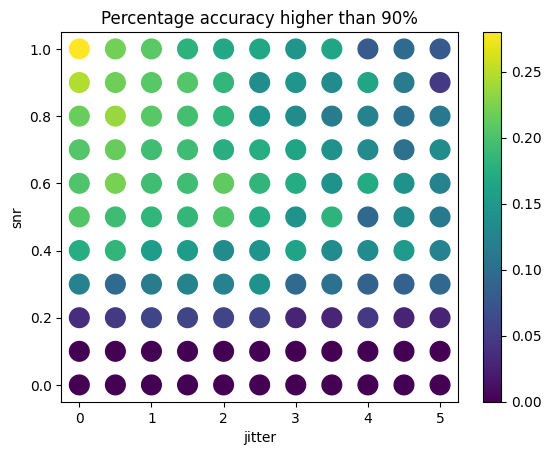

In [138]:
plt.scatter(grid_matrix[:,0], grid_matrix[:,1], s=200, c=grid_matrix[:,2], cmap='viridis')
plt.xlabel('jitter')
plt.ylabel('snr')
plt.colorbar()
plt.title('Percentage accuracy higher than 90%')
plt.savefig('plot.png')
plt.show()


### 2. Testing noise levels

In [11]:
def evaluate_noise(opt_pars, ssn_pars, grid_pars,  conn_pars, train_data, filter_pars,  conv_pars):

    signs=np.array([[1, -1], [1, -1]])
    
    J_2x2 =np.exp(opt_pars['logJ_2x2'])*signs
    s_2x2 = np.exp(opt_pars['logs_2x2'])
    
    #Initialise network
    ssn=SSN2DTopoV1_AMPAGABA_ONOFF(ssn_pars=ssn_pars, grid_pars=grid_pars, conn_pars=conn_pars, filter_pars=filter_pars, J_2x2=J_2x2, s_2x2=s_2x2)

    #Apply Gabor filters to stimuli
    output_ref=np.matmul(ssn.gabor_filters, train_data['ref'])*ssn.A
    output_target=np.matmul(ssn.gabor_filters, train_data['target'])*ssn.A

    #Rectify output
    SSN_input_ref=np.maximum(0, output_ref)
    SSN_input_target=np.maximum(0, output_target) # - baseline input

    #Input to SSN
    r_init = np.zeros(SSN_input_ref.shape[0])

    fp_ref, _ = ssn.fixed_point_r(SSN_input_ref, r_init=r_init, **conv_pars)
    x_ref = ssn.apply_bounding_box(fp_ref, size=3.2)

    fp_target, _ = ssn.fixed_point_r(SSN_input_target, r_init=r_init, **conv_pars)
    x_target = ssn.apply_bounding_box(fp_target, size=3.2)

    return np.linalg.norm(x_ref - x_target), SSN_input_ref

def vmap_evaluate_noise(stimuli_pars, opt_pars, ssn_pars, grid_pars, conn_pars, filter_pars,  conv_pars, offset=1):
        
    #Create gratings at given or ientation and list of labels
    train_data = create_testing_data(stimuli_pars, jitter_val, snr, number=100, offset = 5, ref_ori=55)

    plt.imshow(train_data['ref'][0].reshape(129, 129))

    vmap_eval_noise = vmap(evaluate_noise, in_axes = ({'b_sig': None, 'logJ_2x2': None, 'logs_2x2': None, 'w_sig': None}, None, None, {'PERIODIC': None, 'p_local': [None, None], 'sigma_oris': None},  {'ref':0, 'target':0, 'label':0}, {'conv_factor': None, 'degree_per_pixel': None, 'edge_deg': None, 'k': None, 'sigma_g': None}, {'Tmax': None, 'dt': None, 'silent': None, 'verbose': None, 'xtol': None}) )
    x_vectors, SSN_inputs = vmap_eval_noise(opt_pars, ssn_pars, grid_pars, conn_pars, train_data, filter_pars,  conv_pars)
    
    mean = np.mean(x_vectors)
    std = np.std(x_vectors)
    
    output_snr = mean/std
    
    return mean, std, output_snr, SSN_inputs

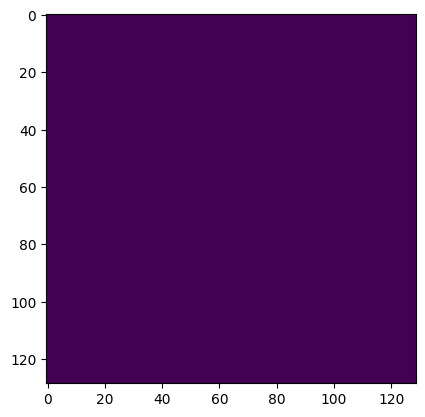

In [12]:
#Stimuli parameters
stimuli_pars = dict(outer_radius=3, inner_radius=2.5, grating_contrast=0, snr = 0)
stimuli_pars.update(general_pars)

mean, std, output_snr, SSN_inputs = vmap_evaluate_noise(stimuli_pars, opt_pars, ssn_pars, grid_pars, conn_pars, filter_pars,  conv_pars)

(DeviceArray(2.9141607, dtype=float32),
 DeviceArray(0.95722467, dtype=float32),
 DeviceArray(3.0443854, dtype=float32))

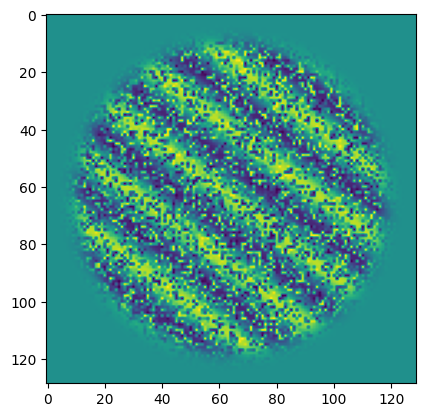

In [9]:
#Stimuli parameters
stimuli_pars = dict(outer_radius=3, inner_radius=2.5, grating_contrast=0.8, snr = 0.5)
stimuli_pars.update(general_pars)

vmap_evaluate_noise(stimuli_pars, opt_pars, ssn_pars, grid_pars, conn_pars, filter_pars,  conv_pars)

In [50]:
stimuli_pars = dict(outer_radius=3, inner_radius=2.5, grating_contrast=0.99, snr =1)
stimuli_pars.update(general_pars)
train_data = create_gratings(ref_ori=55, number=1, offset= 1, jitter_val=5, **stimuli_pars)
train_data = train_data[0]
#train_data = next(iter(DataLoader(train_data, batch_size=len(train_data), shuffle=False)))

## Histograms

In [162]:
def vmap_sigmoid(opt_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars):
    
    eval_vmap = vmap(eval_model, in_axes = ({'b_sig': None, 'logJ_2x2': None, 'logs_2x2': None, 'w_sig': None}, None, None, {'PERIODIC': None, 'p_local': [None, None], 'sigma_oris': None},  {'ref':0, 'target':0, 'label':0}, {'conv_factor': None, 'degree_per_pixel': None, 'edge_deg': None, 'k': None, 'sigma_g': None}, {'Tmax': None, 'dt': None, 'silent': None, 'verbose': None, 'xtol': None}) )
    _, _, dots_output = eval_vmap(opt_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars)
    
    return dots_output

    

def histograms(opt_pars, ssn_pars, grid_pars, conn_pars, filter_pars,  conv_pars, stimuli_pars, jitter_val, snr, trials = 9):
    
    #intitialise empty trials list
    all_trials=[]
    all_w_sigs = []
    

    #initialise random key
    key = random.PRNGKey(60)
    train_data = create_testing_data(jitter_val = jitter_val, snr = snr, stimuli_pars = stimuli_pars)
    
    for i in range (trials):
        
        key, _ = random.split(key)
        opt_pars['w_sig'] = random.normal(key, shape = (N_neurons,)) / np.sqrt(N_neurons)
        all_w_sigs.append(opt_pars['w_sig'])

        #Create gratings at given or ientation and list of labels
        
        sigmoid_output =vmap_sigmoid(opt_pars, ssn_pars, grid_pars, conn_pars, train_data, filter_pars,  conv_pars)
        
        
        all_trials.append(sigmoid_output)
        
    
    #create plots
    n_rows =  int(np.sqrt(trials))
    n_cols = int(np.ceil(trials / n_rows))
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15,15))
    fig.suptitle('SNR: '+str(snr)+', jitter: '+str(jitter_val))

    count = 0
    
    
   #plot histograms
    for k in range(n_rows):
        for j in range (n_cols):
            axs[k,j].hist(all_trials[count])
            axs[k,j].set_xlabel('Sigmoid output')
            axs[k,j].set_ylabel('Frequency')
            axs[k,j].set_title('std = '+str(np.round(np.std(all_trials[count]), 3)), fontsize=10)
            count+=1
    
    fig.savefig('sigmoid_output_snr' + str(snr)+ '.png')
    
    return all_trials, all_w_sigs



TypeError: can only concatenate str (not "int") to str

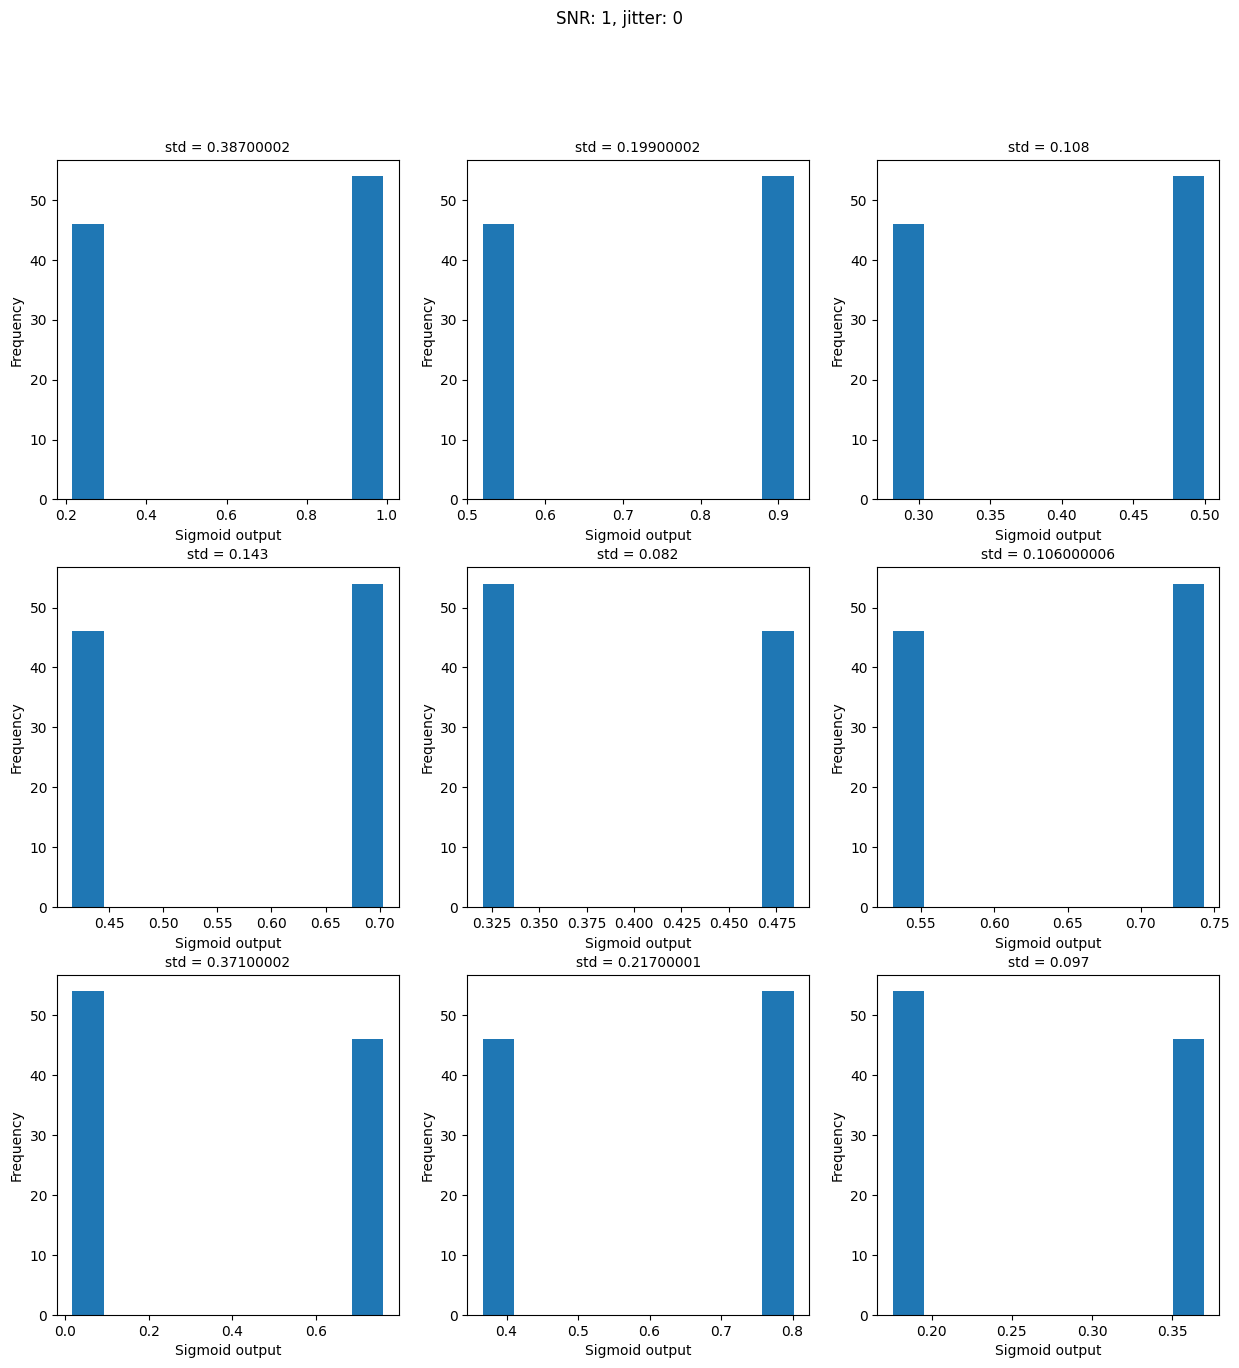

In [158]:
sig_trials, w_sigs = histograms(opt_pars, ssn_pars, grid_pars, conn_pars, filter_pars,  conv_pars, stimuli_pars, jitter_val = 0, snr = 1, trials = 9)

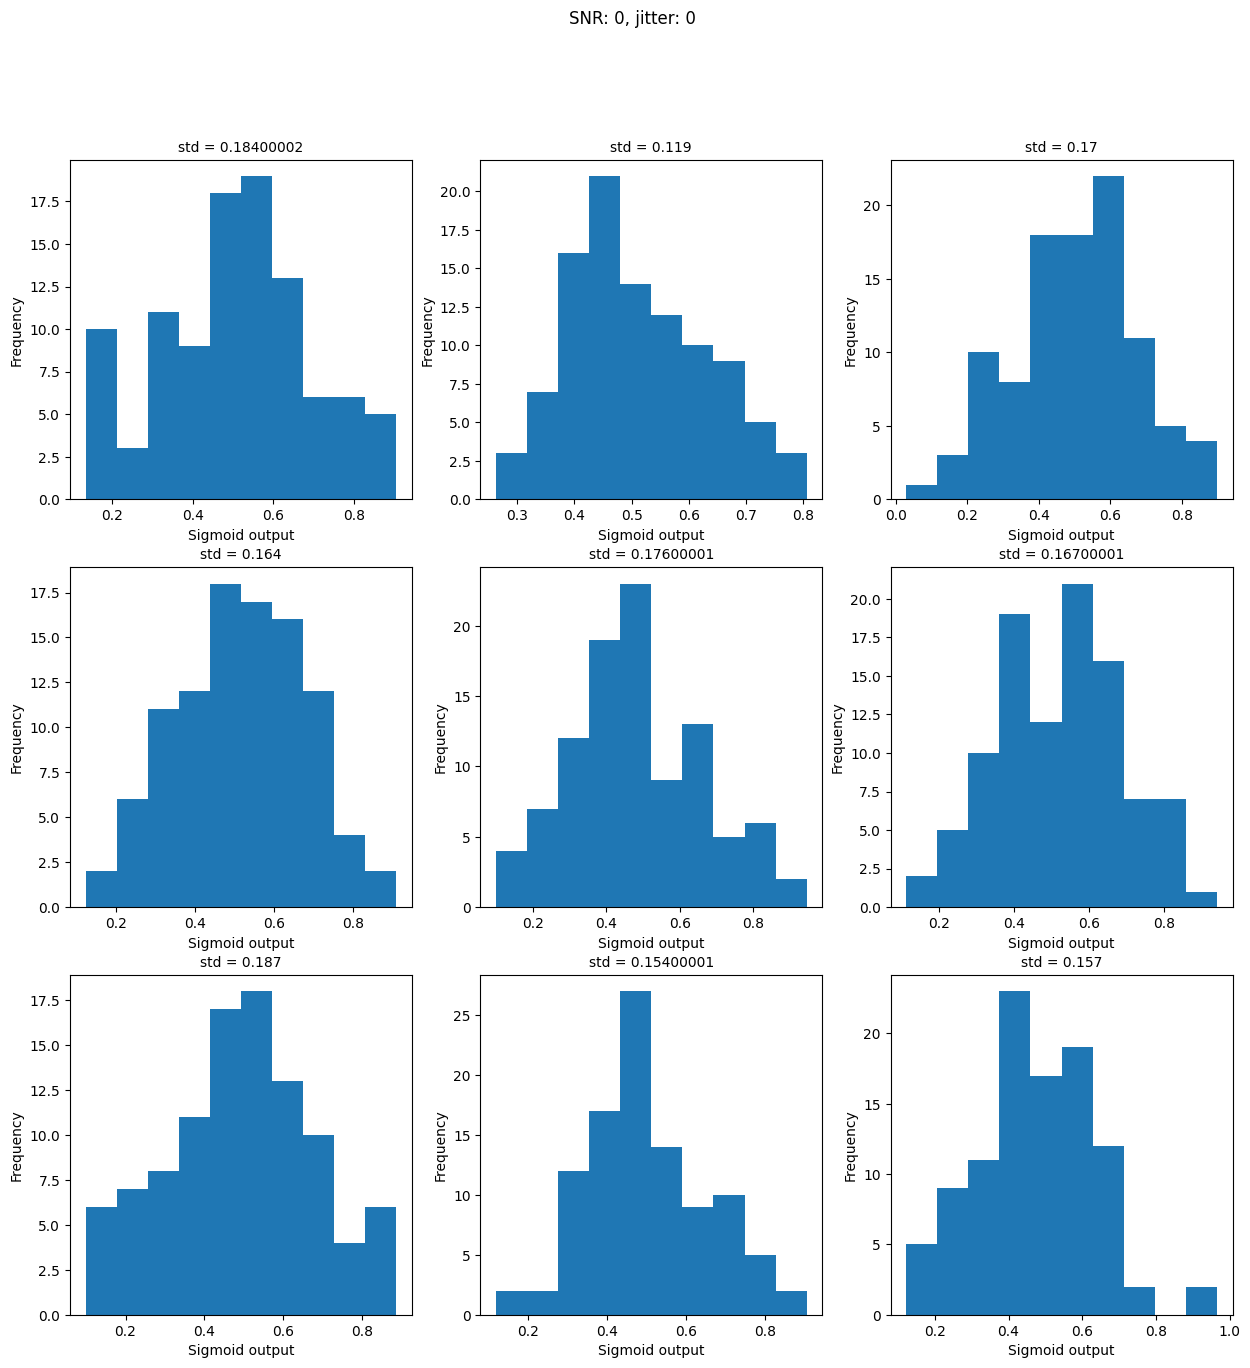

In [161]:
sig_trials_, _ = histograms(opt_pars, ssn_pars, grid_pars, conn_pars, filter_pars,  conv_pars, stimuli_pars, jitter_val = 0, snr = 0, trials = 9)

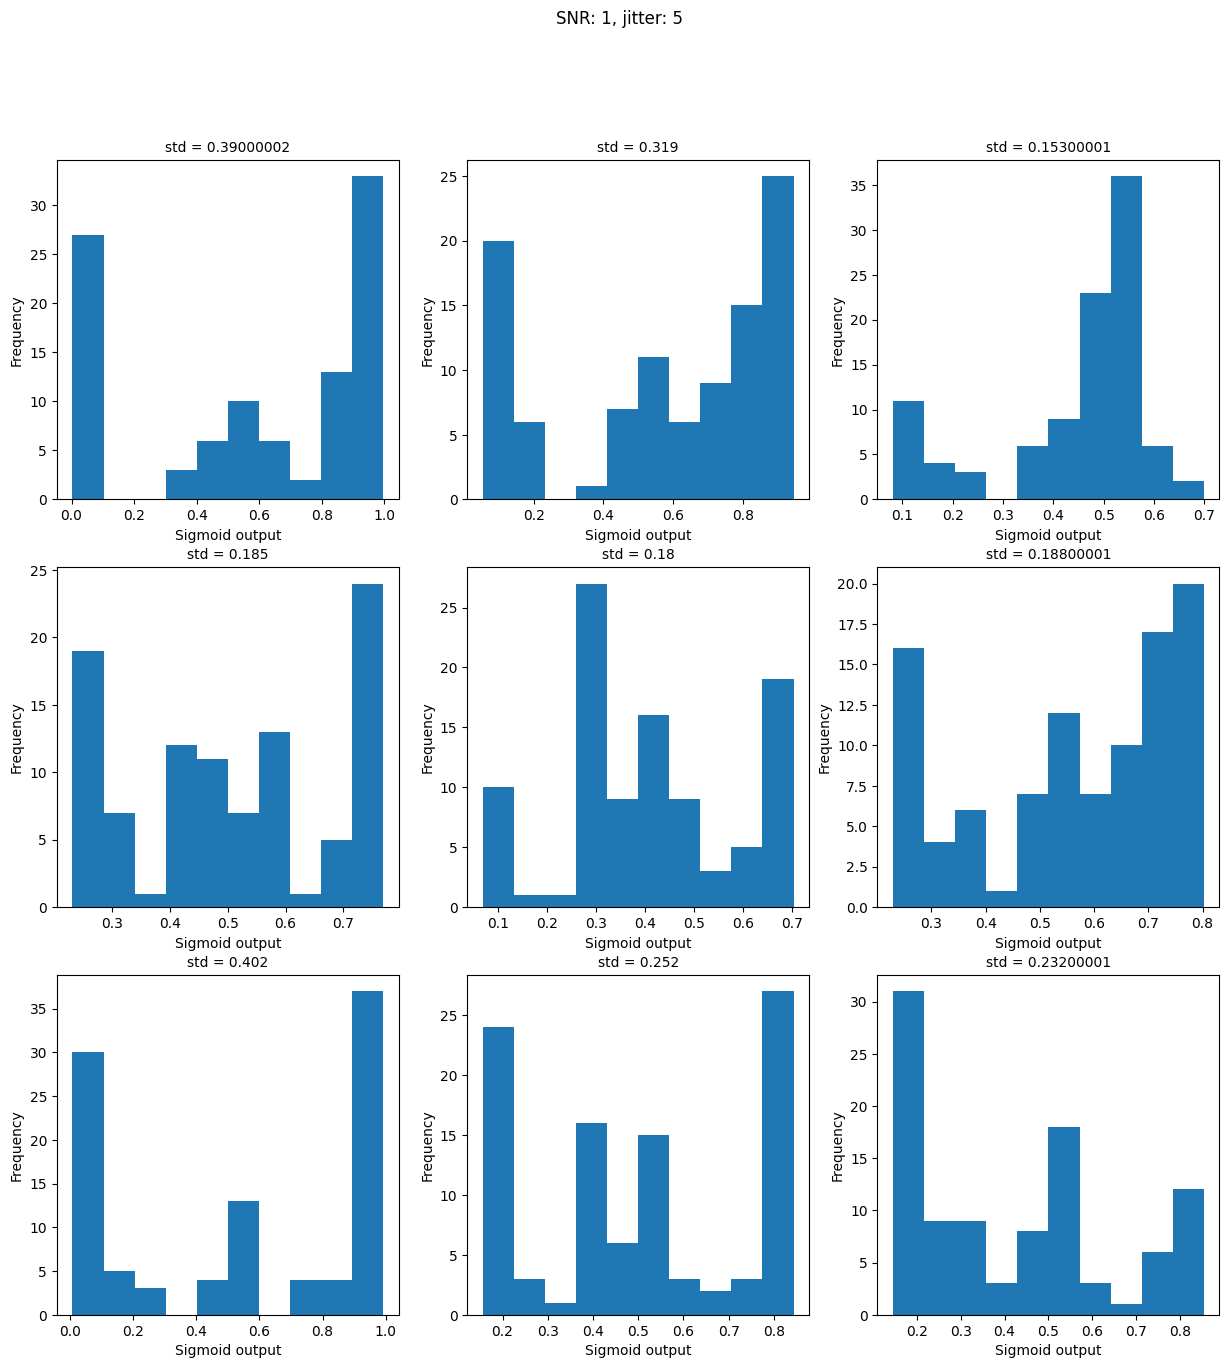

In [164]:
sig_trials_, _ = histograms(opt_pars, ssn_pars, grid_pars, conn_pars, filter_pars,  conv_pars, stimuli_pars, jitter_val = 5, snr = 1, trials = 9)

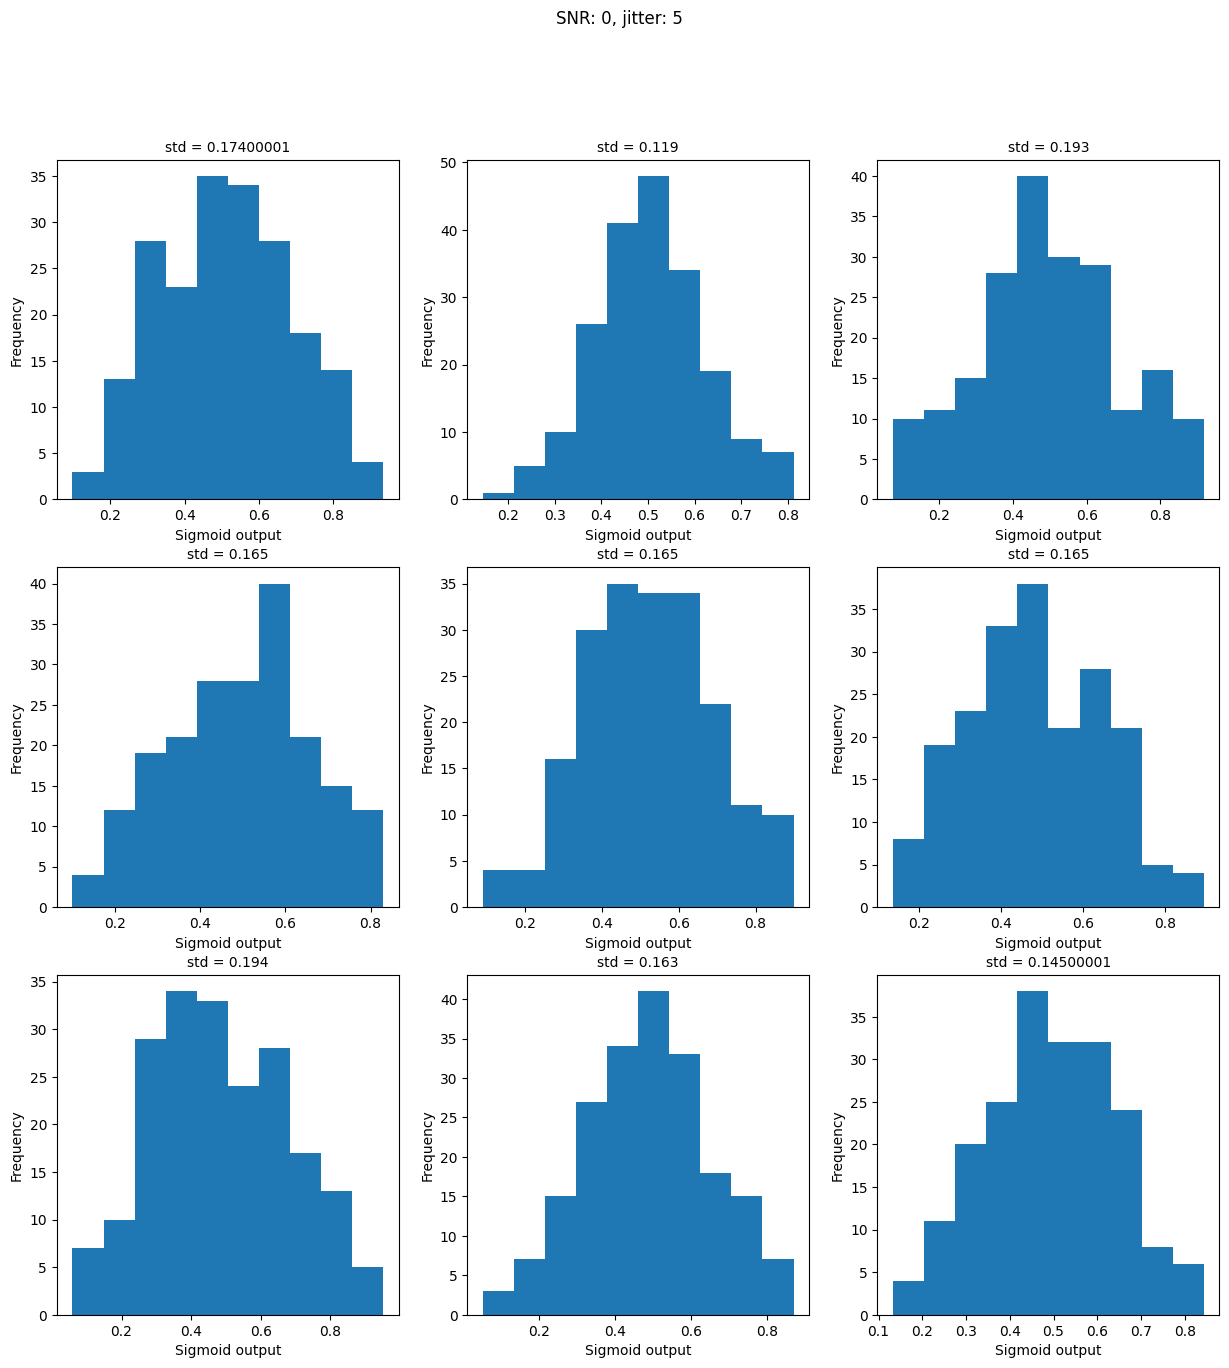

In [12]:
sig_trials_, _ = histograms(opt_pars, ssn_pars, grid_pars, conn_pars, filter_pars,  conv_pars, jitter_val = 5, snr = 0, trials = 9)

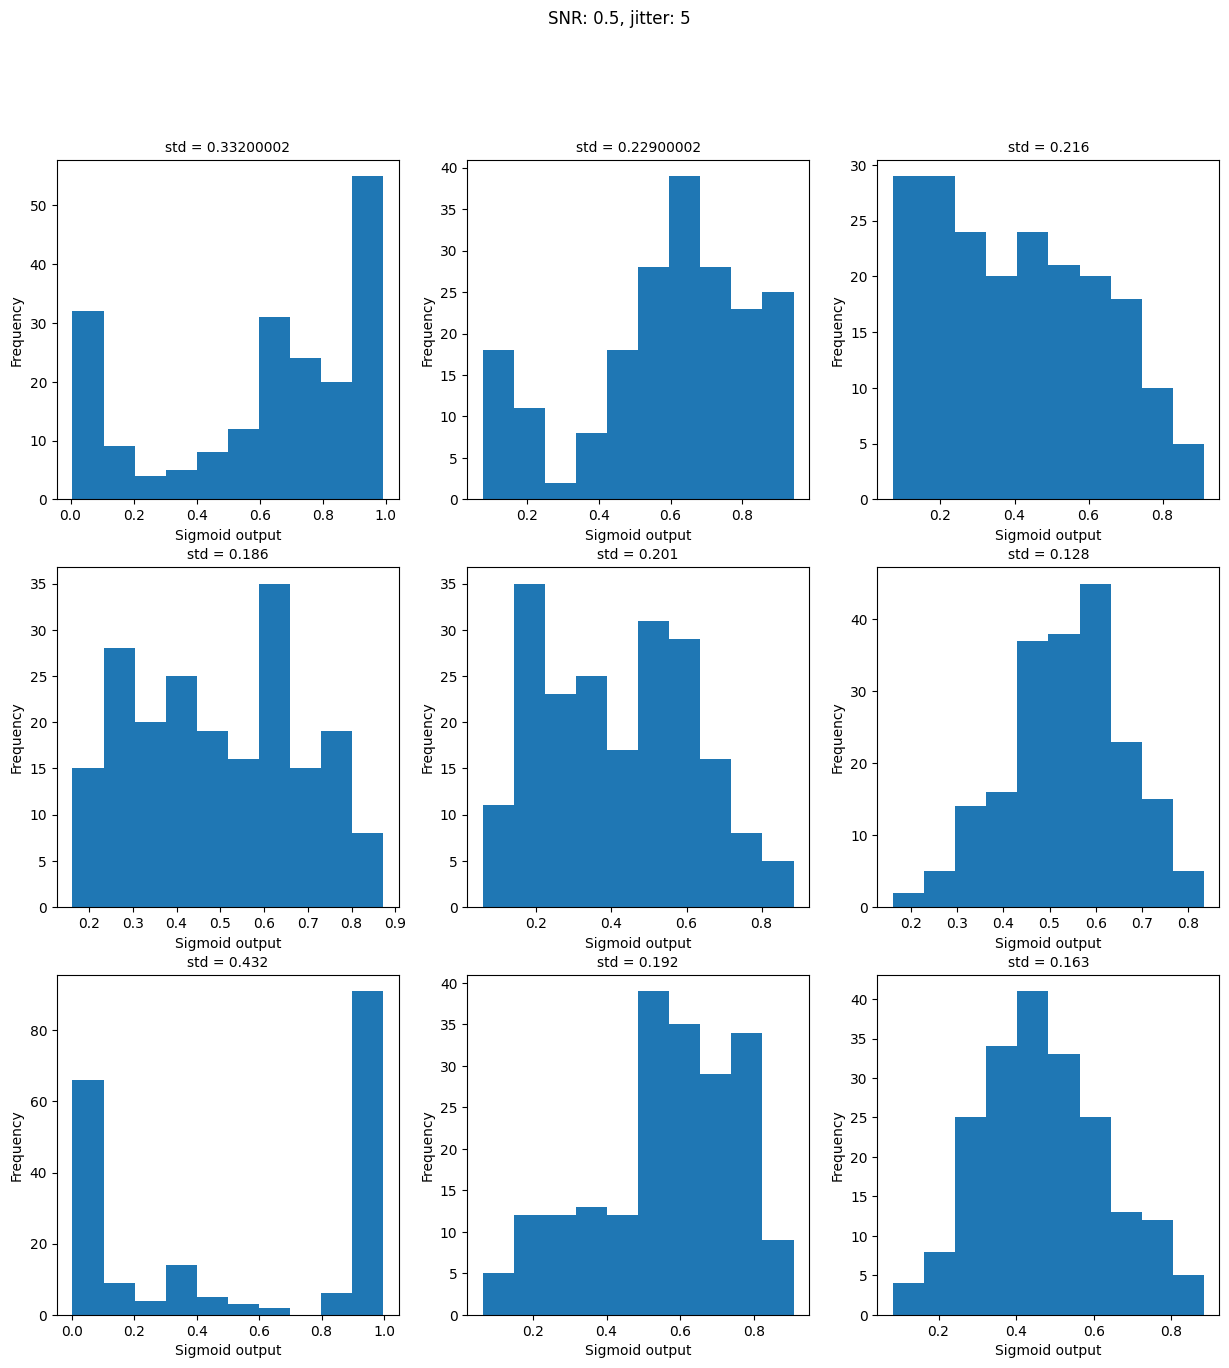

In [14]:
sig_trials_, _ = histograms(opt_pars, ssn_pars, grid_pars, conn_pars, filter_pars,  conv_pars, jitter_val = 5, snr = 0.5, trials = 9)

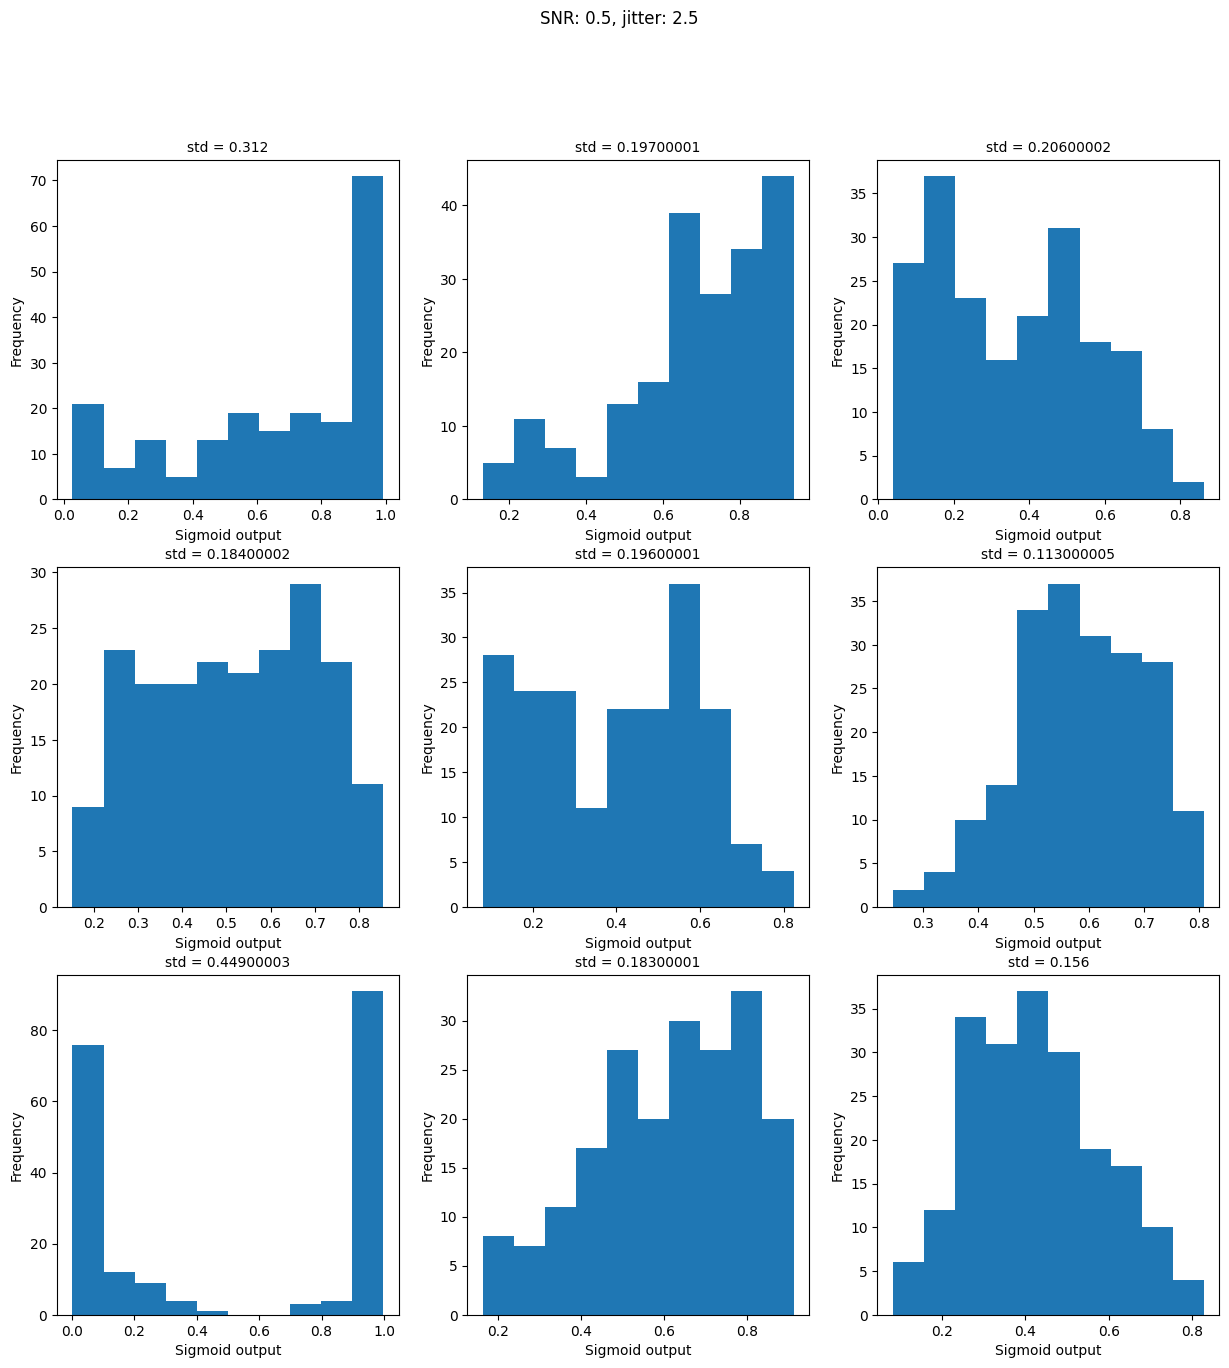

In [15]:
sig_trials_, _ = histograms(opt_pars, ssn_pars, grid_pars, conn_pars, filter_pars,  conv_pars, jitter_val = 2.5, snr = 0.5, trials = 9)